# Conditional UNet Inference
This notebook demonstrates how to load a trained Conditional UNet model and generate colored polygon images based on grayscale input and a target color name.

In [2]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from model import ConditionalUNet

## Configuration and Paths

In [3]:
config = {
    "img_size": 64,
    "embed_dim": 512,
    "colour_names": ["red", "green", "blue", "yellow", "orange", "purple", "cyan", "magenta", "lime", "pink"]
}

model_path = r'C:\Users\aswin\OneDrive\Desktop\Sandbox\Ayna UNET Model\wandb\models\conditional_unet_50mod.pth'
input_image_path = r'C:\Users\aswin\OneDrive\Desktop\Sandbox\Ayna UNET Model\dataset\validation\inputs\octagon.png'
desired_colour_name = 'red'

## Load Model

In [4]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(model_path, config, device):
    model = ConditionalUNet(
        n_channels=1,
        n_classes=3,
        num_colors=len(config['colour_names']),
        embed_dim=config['embed_dim']
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

device = get_device()
model = load_model(model_path, config, device)

## Preprocess Input Image

In [5]:
def preprocess_image(image_path, img_size):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    return transform(image).unsqueeze(0)

input_tensor = preprocess_image(input_image_path, config['img_size'])

## Map Color and Run Inference

In [6]:
def infer(model, input_tensor, color_idx, device):
    input_tensor = input_tensor.to(device)
    color_idx_tensor = torch.tensor([color_idx], device=device)
    with torch.no_grad():
        prediction = model(input_tensor, color_idx_tensor)
    prediction = prediction.squeeze(0).cpu().numpy()
    prediction = np.transpose(prediction, (1, 2, 0))
    prediction = np.clip(prediction, 0, 1)
    return prediction

colour_map = {name: i for i, name in enumerate(config['colour_names'])}
color_idx = colour_map[desired_colour_name]
prediction = infer(model, input_tensor, color_idx, device)

## Visualize Results

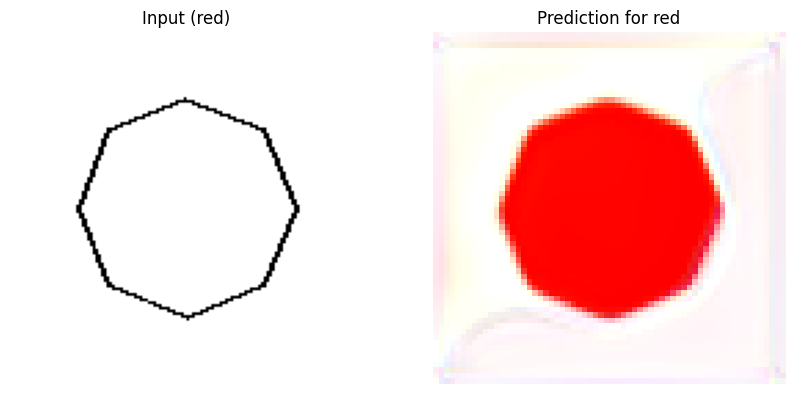

In [7]:
def visualize_prediction(input_img_path, prediction, colour_name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    input_img = Image.open(input_img_path)
    axes[0].imshow(input_img, cmap='gray')
    axes[0].set_title(f"Input ({colour_name})")
    axes[0].axis('off')
    axes[1].imshow(prediction)
    axes[1].set_title(f"Prediction for {colour_name}")
    axes[1].axis('off')
    plt.show()

visualize_prediction(input_image_path, prediction, desired_colour_name)